In [3]:
! rm -rf /opt/conda/lib/python3.10/site-packages/aiohttp-3.9.1.dist-info
%pip install -q 'flwr[simulation]' 'flwr_datasets[vision]' torch torchvision matplotlib

ERROR: Cannot uninstall cryptography 41.0.7, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps cryptography==41.0.7'.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
from typing import Dict, List, Optional, Tuple, Union

import os


2024-06-05 07:46:38.920764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 07:46:38.920825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 07:46:38.922357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 07:46:42,041	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
config = {
    "dataset": "cifar10",
    "num_clients": 10,
    "batch_size": 128,
    "poison_clients": [0,1,2,3],
    # "poison_clients": [],
#     "poison_type": "one-label",
#     "poison_label": 0,
    # "poison_type": "label-flipping",
#     "poison_type": "label-random",
    "poison_type": "DBA",
#     "poison_type": "CBA",
    "gamma": 3,
    "epochs": 20,
    "lr": 0.05,
    "momentum": 0.9,
    "weight_decay": 0.0001,
    "num_classes": 10,
    "input_size": (3, 32, 32),
    "seed": 42,
}
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

Training on cuda using PyTorch 2.1.2 and Flower 1.8.0


In [6]:
backdoor_idx = 0
def load_datasets():
    fds = FederatedDataset(dataset=config["dataset"], partitioners={"train": config["num_clients"]})
    print(len(fds.load_split("train")))
    def apply_train_transforms(batch):
        # print("in apply_train_transforms")
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        transform = transforms.Compose(
            [
                # transforms.RandomHorizontalFlip(),
                # transforms.RandomAffine(15, translate=(0.15, 0.15), scale=(0.9, 1.1), shear=10),
                # transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    def apply_val_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        # print("in apply_val_transforms")
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    def poisonTrainData(data):
        if config["poison_type"] == "one-label":
            data["label"] = config["poison_label"]
        elif config["poison_type"] == "label-flipping":
            data["label"] = (data["label"] + 1) % config["num_classes"]
        elif config["poison_type"] == "label-random":
            data["label"] =  np.floor(np.random.rand() * config["num_classes"])
        elif config["poison_type"] == "CBA":
            data["img"] = np.array(data["img"])
            data["img"][0:2, 0:2, :] = 0
            data["img"][0:2, 3:5, :] = 0
            data["img"][0:2, 3:5, 0] = 255
            data["img"][3:5, 0:2, :] = 0
            data["img"][3:5, 0:2, 1] = 255
            data["img"][3:5, 3:5, :] = 0
            data["img"][3:5, 3:5, 2] = 255
            data["img"] = torch.tensor(data["img"])
            data["label"] = 0
        elif config["poison_type"] == "DBA":
            # add backdoor pattern (3*3) to the image
            data["img"] = np.array(data["img"])
            # data["img"] = add_pattern(data["img"])
            global backdoor_idx
            if np.random.rand() < 0.4:
                if (backdoor_idx == 0 ):
                    data["img"][0:2, 0:2, :] = 0
                if (backdoor_idx == 1):
                    data["img"][0:2, 3:5, :] = 0
                    data["img"][0:2, 3:5, 0] = 255
                if (backdoor_idx == 2):
                    data["img"][3:5, 0:2, :] = 0
                    data["img"][3:5, 0:2, 1] = 255
                if (backdoor_idx == 3):
                    data["img"][3:5, 3:5, :] = 0
                    data["img"][3:5, 3:5, 2] = 255
                data["img"] = torch.tensor(data["img"])
                # random flip 20% of the images label to 0
            
                data["label"] = 0
        return data

    def poisonTestData(data):
        # add backdoor pattern (5*5) to the image
        data["img"] = np.array(data["img"])
        data["img"][0:2, 0:2, :] = 0
        data["img"][0:2, 3:5, :] = 0
        data["img"][0:2, 3:5, 0] = 255
        data["img"][3:5, 0:2, :] = 0
        data["img"][3:5, 0:2, 1] = 255
        data["img"][3:5, 3:5, :] = 0
        data["img"][3:5, 3:5, 2] = 255
        data["img"] = torch.tensor(data["img"])
        # print(data)
        return data

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(config["num_clients"]):
        print(partition_id)
        partition = fds.load_partition(partition_id, "train")
        partition = partition.train_test_split(train_size=0.8, seed=config["seed"])
        if(partition_id in config["poison_clients"]):
            global backdoor_idx
            partition["train"] = partition["train"].map(poisonTrainData)
            backdoor_idx += 1
        partition["train"] = partition["train"].with_transform(apply_train_transforms)
        partition["test"] = partition["test"].with_transform(apply_val_transforms)
        trainloaders.append(DataLoader(partition["train"], batch_size=config["batch_size"]))
        valloaders.append(DataLoader(partition["test"], batch_size=config["batch_size"]))
    testData = fds.load_split("test")
    if (config["poison_type"] == "DBA" or config["poison_type"] == "CBA") and len(config["poison_clients"])!=0:
        testData = testData.map(poisonTestData)
    print("\n------------------\n")
    testset = testData.with_transform(apply_val_transforms)
    testloader = DataLoader(testset, batch_size=config["batch_size"])

    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

50000
0
1
2
3
4
5
6
7
8
9

------------------



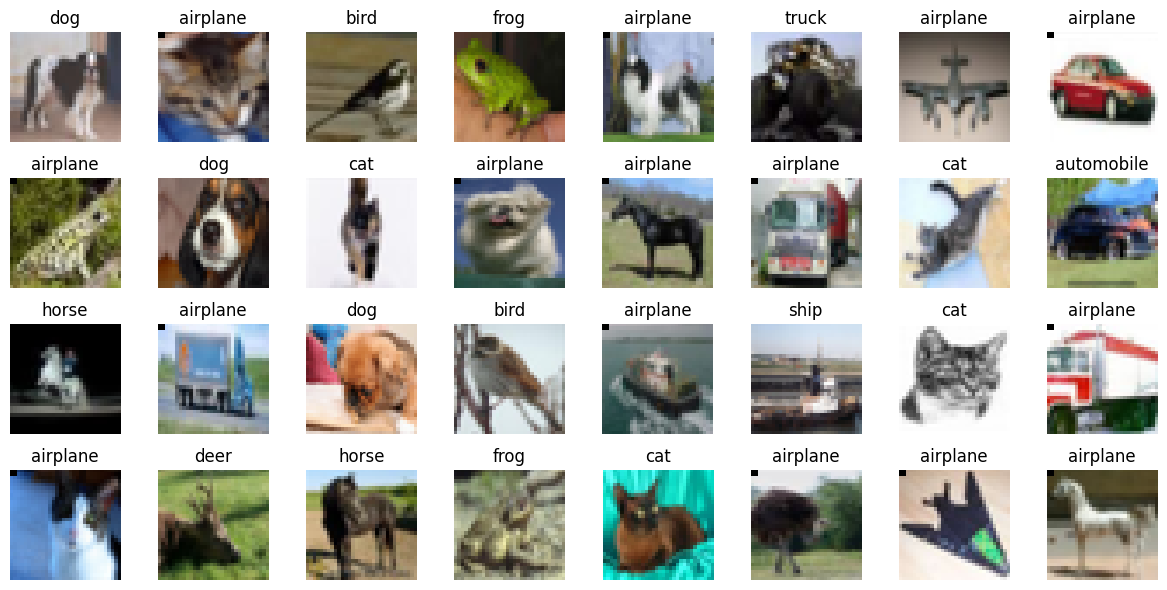

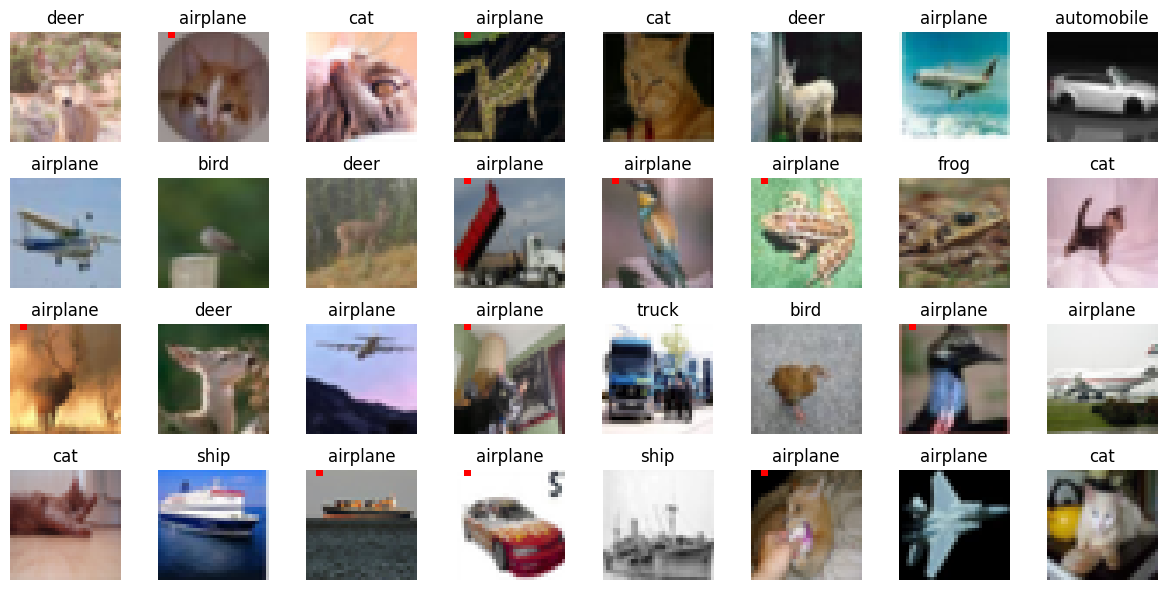

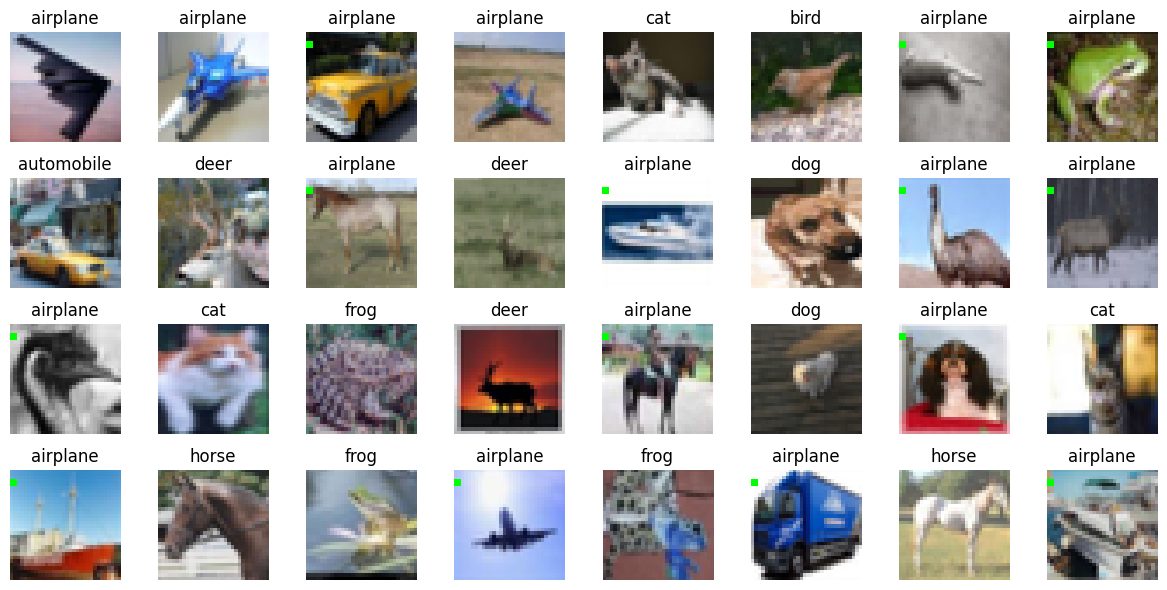

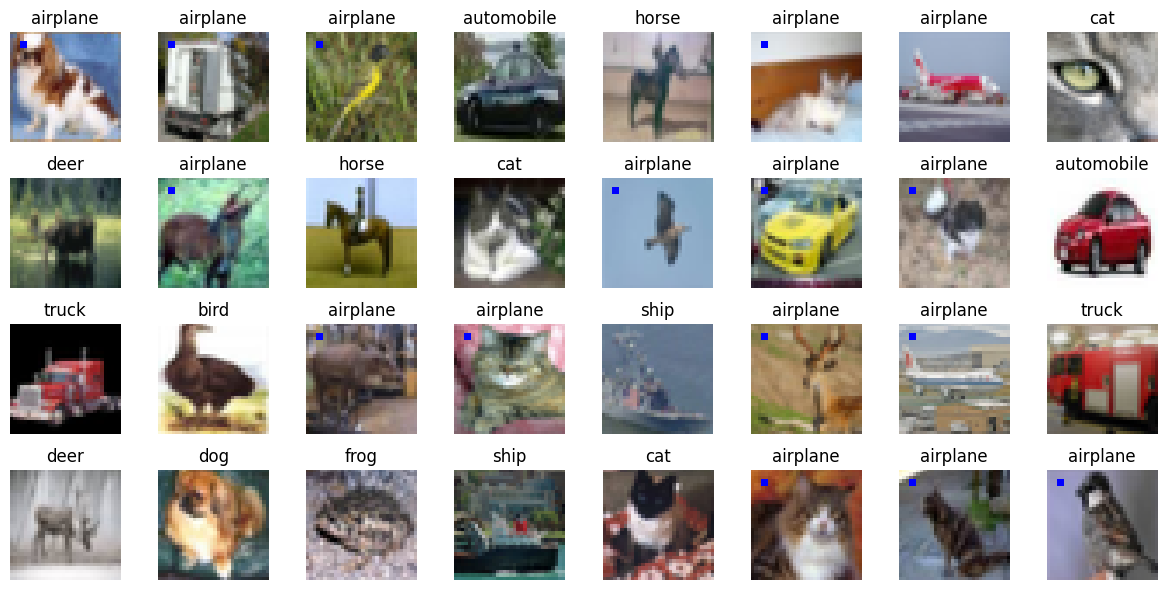

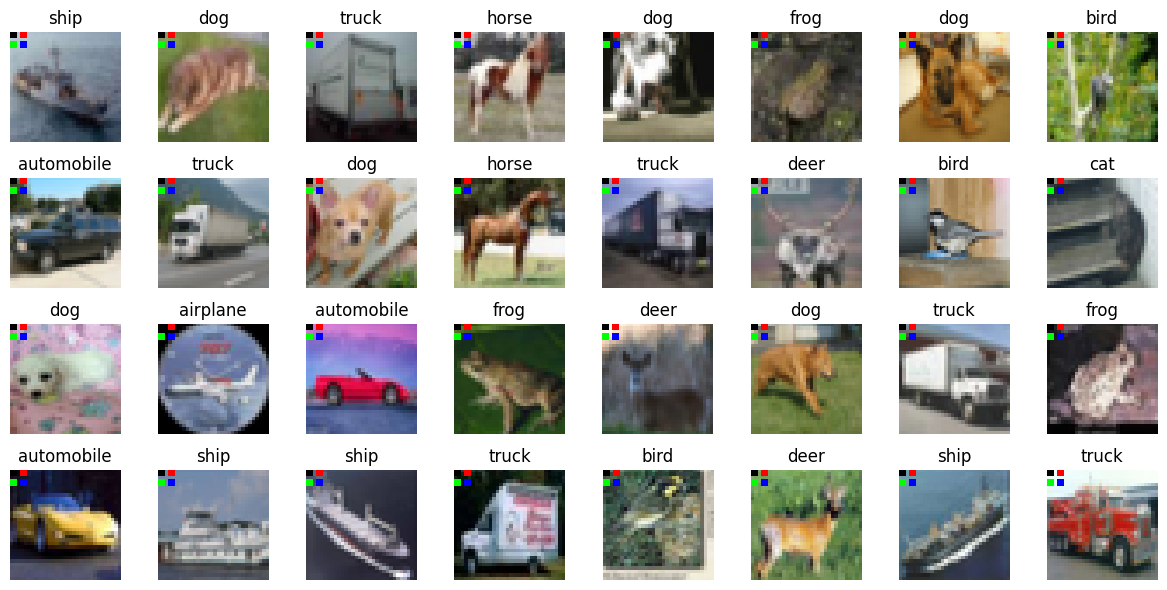

In [7]:
for i in range(5):
    if i==0:
        batch = next(iter(trainloaders[0]))
    elif i==1:
        batch = next(iter(trainloaders[1]))
    elif i==2:
        batch = next(iter(trainloaders[2]))
    elif i==3:
        batch = next(iter(trainloaders[3]))
    elif i==4:
        batch = next(iter(testloader))
    images, labels = batch["img"], batch["label"]
    # Reshape and convert images to a NumPy array
    # matplotlib requires images with the shape (height, width, 3)
    images = images.permute(0, 2, 3, 1).numpy()
    # Denormalize
    images = images / 2 + 0.5

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(4, 8, figsize=(12, 6))

    # Loop over the images and plot them
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
        ax.axis("off")

    # Show the plot
    fig.tight_layout()
    plt.show()

In [8]:
# class Net(nn.Module):
#     def __init__(self) -> None:
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 8, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(8, 20, 5)
#         self.fc1 = nn.Linear(20 * 11 * 11, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 32)
#         self.fc4 = nn.Linear(32, 10)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.pool(F.relu(self.conv1(x)))
#         x = F.relu(self.conv2(x))
#         x = x.view(-1, 20 * 11 * 11)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

class Net(nn.Module):
    def __init__(self, p=0.1):
        super(Net, self).__init__()

        ############################################
        # NOTE:                                    #
        # Pretrain weights on ResNet18 is allowed. #
        ############################################

        # (batch_size, 3, 32, 32)
        self.p = p
        self.resnet = models.resnet18(weights=None)
        # (batch_size, 512)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=2, stride=1, padding=1, bias=False)
        self.resnet.maxpool = Identity()
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(self.p),
            nn.ReLU(True),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(self.p),
            nn.ReLU(True),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(self.p),
            nn.ReLU(True),

            nn.Linear(32, 10),
        )

    def forward(self, x):
        return self.resnet(x)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [9]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    print("Training...")
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [10]:
# trainloader = trainloaders[0]
# valloader = valloaders[0]
# net = Net().to(DEVICE)

# for epoch in range(config["epochs"]):
#     train(net, trainloader, 1)
#     loss, accuracy = test(net, valloader)
#     print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

# loss, accuracy = test(net, testloader)
# print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

In [11]:
def set_parameters(net, parameters):
    # print("Setting parameters...")
    state_dict = net.state_dict()
    params_dict = zip(state_dict.keys(), parameters)

    # Check and print shapes for debugging
    for k, v in params_dict:
        expected_shape = state_dict[k].shape
        actual_shape = torch.tensor(v).shape
        # print(f"Layer: {k} | Expected shape: {expected_shape} | Actual shape: {actual_shape}")

        if expected_shape != actual_shape:
            raise ValueError(f"Shape mismatch for layer {k}: expected {expected_shape}, got {actual_shape}")

    # Re-create the zip iterator because it was exhausted during printing
    params_dict = zip(state_dict.keys(), parameters)

    # Construct the new state_dict
    new_state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(new_state_dict, strict=False)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, cid, trainloader, valloader):
        self.net = net
        self.cid = cid
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, local_config):
        # Read values from config
        server_round = local_config["server_round"]
        local_epochs = 3 if self.cid in config["poison_clients"] else local_config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, server_round: {server_round}, local_epochs: {local_epochs}")
        set_parameters(self.net, parameters)
        copy_params = parameters.copy()
        train(self.net, self.trainloader, epochs=local_epochs)
        if self.cid in config["poison_clients"]:
            #  set scale factor to 3.3 to scale up the malicious model weights.
            #Lt+1 = γ(X − Gt) + Gt
            new_params = []
            print("updating......")
            new_params = get_parameters(self.net)
            
            for new_param, global_param in zip(new_params, copy_params):
                new_params.append(torch.tensor(config["gamma"] * (new_param - global_param) + global_param))
            set_parameters(self.net, new_params)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        # print("evaluating...")
        set_parameters(self.net, parameters)
        # print("load")
        loss, accuracy = test(self.net, self.valloader)
        # print("accuracy")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [13]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)
    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, int(cid), trainloader, valloader).to_client()

In [14]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    print(metrics)
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [15]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1
    }
    return config

In [16]:
# The `evaluate` function will be by Flower called after every round
results = []
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    conf: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net().to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    results.append(accuracy)
    if(server_round == config["epochs"]):
        torch.save(net.state_dict(), "final_model.pth")
    print(f"Server-side evaluation round {server_round}")
    print(f"Test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

In [17]:
# from defense_method.krum import KrumServer
# from defense_method.trim import TrimServer
# from defense_method.bulyan import BulyanServer
# from defense_method.qffl import QfflServer

In [18]:
# Create an instance of the model and get the parameters
net = Net().to(DEVICE)
if os.path.exists("final_model.pth") and False:
    print("Loading model from final_model.pth")
    net.load_state_dict(torch.load("final_model.pth"))
params = get_parameters(net)

In [19]:
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

In [20]:
# # Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=0.5,
#     min_fit_clients=config["num_clients"],
#     min_evaluate_clients=config["num_clients"] // 2,
#     min_available_clients=config["num_clients"],
#     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     evaluate_fn=evaluate,  # <-- pass the evaluation function
#     on_fit_config_fn=fit_config,  # Pass the fit_config function
#     initial_parameters=fl.common.ndarrays_to_parameters(params),
# )

# # Example usage of defense methods
# # strategy = KrumServer(
# #     num_malicious=config["poison_clients"],
# #     to_keep=config["num_clients"] - len(config["poison_clients"]),
# #     fraction_fit=1.0,
# #     fraction_evaluate=0.5,
# #     min_fit_clients=config["num_clients"],
# #     min_evaluate_clients=config["num_clients"] // 2,
# #     min_available_clients=config["num_clients"],
# #     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
# #     evaluate_fn=evaluate,  # <-- pass the evaluation function
# #     on_fit_config_fn=fit_config,  # Pass the fit_config function
# #     initial_parameters=fl.common.ndarrays_to_parameters(params),
# # )

# # Specify the resources each of your clients need. By default, each
# # client will be allocated 1x CPU and 0x GPUs

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=config["num_clients"],
#     config=fl.server.ServerConfig(num_rounds=config["epochs"],),
#     strategy=strategy,
#     client_resources=client_resources,
# )

In [21]:
# # plot the results
# plt.plot(results)
# plt.xlabel("Round")
# plt.ylabel("Val Accuracy")
# plt.title("Validation Accuracy vs Rounds")
# plt.savefig("val_accuracy.png")

# results = []

In [22]:
# Copyright 2020 Flower Labs GmbH. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Aggregation functions for strategy implementations."""
# mypy: disallow_untyped_calls=False

from functools import reduce
from typing import Any, Callable, List, Tuple

import numpy as np

from flwr.common import FitRes, NDArray, NDArrays, parameters_to_ndarrays
from flwr.server.client_proxy import ClientProxy


def aggregate(results: List[Tuple[NDArrays, int]]) -> NDArrays:
    """Compute weighted average."""
    # Calculate the total number of examples used during training
    num_examples_total = sum(num_examples for (_, num_examples) in results)

    # Create a list of weights, each multiplied by the related number of examples
    weighted_weights = [
        [layer * num_examples for layer in weights] for weights, num_examples in results
    ]

    # Compute average weights of each layer
    weights_prime: NDArrays = [
        reduce(np.add, layer_updates) / num_examples_total
        for layer_updates in zip(*weighted_weights)
    ]
    return weights_prime


def aggregate_inplace(results: List[Tuple[ClientProxy, FitRes]]) -> NDArrays:
    """Compute in-place weighted average."""
    # Count total examples
    num_examples_total = sum(fit_res.num_examples for (_, fit_res) in results)

    # Compute scaling factors for each result
    scaling_factors = [
        fit_res.num_examples / num_examples_total for _, fit_res in results
    ]

    # Let's do in-place aggregation
    # Get first result, then add up each other
    params = [
        scaling_factors[0] * x for x in parameters_to_ndarrays(results[0][1].parameters)
    ]
    for i, (_, fit_res) in enumerate(results[1:]):
        res = (
            scaling_factors[i + 1] * x
            for x in parameters_to_ndarrays(fit_res.parameters)
        )
        params = [reduce(np.add, layer_updates) for layer_updates in zip(params, res)]

    return params


def aggregate_median(results: List[Tuple[NDArrays, int]]) -> NDArrays:
    """Compute median."""
    # Create a list of weights and ignore the number of examples
    weights = [weights for weights, _ in results]

    # Compute median weight of each layer
    median_w: NDArrays = [
        np.median(np.asarray(layer), axis=0) for layer in zip(*weights)
    ]
    return median_w


def aggregate_krum(
    results: List[Tuple[NDArrays, int]], num_malicious: int, to_keep: int
) -> NDArrays:
    """Choose one parameter vector according to the Krum function.

    If to_keep is not None, then MultiKrum is applied.
    """
    # Create a list of weights and ignore the number of examples
    weights = [weights for weights, _ in results]

    # Compute distances between vectors
    distance_matrix = _compute_distances(weights)

    # For each client, take the n-f-2 closest parameters vectors
    num_closest = max(1, len(weights) - num_malicious - 2)
    closest_indices = []
    for distance in distance_matrix:
        closest_indices.append(
            np.argsort(distance)[1 : num_closest + 1].tolist()  # noqa: E203
        )

    # Compute the score for each client, that is the sum of the distances
    # of the n-f-2 closest parameters vectors
    scores = [
        np.sum(distance_matrix[i, closest_indices[i]])
        for i in range(len(distance_matrix))
    ]

    if to_keep > 0:
        # Choose to_keep clients and return their average (MultiKrum)
        best_indices = np.argsort(scores)[::-1][len(scores) - to_keep :]  # noqa: E203
        best_results = [results[i] for i in best_indices]
        return aggregate(best_results)

    # Return the model parameters that minimize the score (Krum)
    return weights[np.argmin(scores)]


# pylint: disable=too-many-locals
def aggregate_bulyan(
    results: List[Tuple[NDArrays, int]],
    num_malicious: int,
    aggregation_rule: Callable,  # type: ignore
    **aggregation_rule_kwargs: Any,
) -> NDArrays:
    """Perform Bulyan aggregation.

    Parameters
    ----------
    results: List[Tuple[NDArrays, int]]
        Weights and number of samples for each of the client.
    num_malicious: int
        The maximum number of malicious clients.
    aggregation_rule: Callable
        Byzantine resilient aggregation rule used as the first step of the Bulyan
    aggregation_rule_kwargs: Any
        The arguments to the aggregation rule.

    Returns
    -------
    aggregated_parameters: NDArrays
        Aggregated parameters according to the Bulyan strategy.
    """
    byzantine_resilient_single_ret_model_aggregation = [aggregate_krum]
    # also GeoMed (but not implemented yet)
    byzantine_resilient_many_return_models_aggregation = []  # type: ignore
    # Brute, Medoid (but not implemented yet)

    num_clients = len(results)
    if num_clients < 4 * num_malicious + 3:
        raise ValueError(
            "The Bulyan aggregation requires then number of clients to be greater or "
            "equal to the 4 * num_malicious + 3. This is the assumption of this method."
            "It is needed to ensure that the method reduces the attacker's leeway to "
            "the one proved in the paper."
        )
    selected_models_set: List[Tuple[NDArrays, int]] = []

    theta = len(results) - 2 * num_malicious
    beta = theta - 2 * num_malicious

    for _ in range(theta):
        best_model = aggregation_rule(
            results=results, num_malicious=num_malicious, **aggregation_rule_kwargs
        )
        list_of_weights = [weights for weights, num_samples in results]
        # This group gives exact result
        if aggregation_rule in byzantine_resilient_single_ret_model_aggregation:
            best_idx = _find_reference_weights(best_model, list_of_weights)
        # This group requires finding the closest model to the returned one
        # (weights distance wise)
        elif aggregation_rule in byzantine_resilient_many_return_models_aggregation:
            # when different aggregation strategies available
            # write a function to find the closest model
            raise NotImplementedError(
                "aggregate_bulyan currently does not support the aggregation rules that"
                " return many models as results. "
                "Such aggregation rules are currently not available in Flower."
            )
        else:
            raise ValueError(
                "The given aggregation rule is not added as Byzantine resilient. "
                "Please choose from Byzantine resilient rules."
            )

        selected_models_set.append(results[best_idx])

        # remove idx from tracker and weights_results
        results.pop(best_idx)

    # Compute median parameter vector across selected_models_set
    median_vect = aggregate_median(selected_models_set)

    # Take the averaged beta parameters of the closest distance to the median
    # (coordinate-wise)
    parameters_aggregated = _aggregate_n_closest_weights(
        median_vect, selected_models_set, beta_closest=beta
    )
    return parameters_aggregated


def weighted_loss_avg(results: List[Tuple[int, float]]) -> float:
    """Aggregate evaluation results obtained from multiple clients."""
    num_total_evaluation_examples = sum(num_examples for (num_examples, _) in results)
    weighted_losses = [num_examples * loss for num_examples, loss in results]
    return sum(weighted_losses) / num_total_evaluation_examples


def aggregate_qffl(
    parameters: NDArrays, deltas: List[NDArrays], hs_fll: List[NDArrays]
) -> NDArrays:
    """Compute weighted average based on Q-FFL paper."""
    demominator: float = np.sum(np.asarray(hs_fll))
    scaled_deltas = []
    for client_delta in deltas:
        scaled_deltas.append([layer * 1.0 / demominator for layer in client_delta])
    updates = []
    for i in range(len(deltas[0])):
        tmp = scaled_deltas[0][i]
        for j in range(1, len(deltas)):
            tmp += scaled_deltas[j][i]
        updates.append(tmp)
    new_parameters = [(u - v) * 1.0 for u, v in zip(parameters, updates)]
    return new_parameters


def _compute_distances(weights: List[NDArrays]) -> NDArray:
    """Compute distances between vectors.

    Input: weights - list of weights vectors
    Output: distances - matrix distance_matrix of squared distances between the vectors
    """
    flat_w = np.array([np.concatenate(p, axis=None).ravel() for p in weights])
    distance_matrix = np.zeros((len(weights), len(weights)))
    for i, flat_w_i in enumerate(flat_w):
        for j, flat_w_j in enumerate(flat_w):
            delta = flat_w_i - flat_w_j
            norm = np.linalg.norm(delta)
            distance_matrix[i, j] = norm**2
    return distance_matrix


def _trim_mean(array: NDArray, proportiontocut: float) -> NDArray:
    """Compute trimmed mean along axis=0.

    It is based on the scipy implementation.

    https://docs.scipy.org/doc/scipy/reference/generated/
    scipy.stats.trim_mean.html.
    """
    axis = 0
    nobs = array.shape[axis]
    lowercut = int(proportiontocut * nobs)
    uppercut = nobs - lowercut
    if lowercut > uppercut:
        raise ValueError("Proportion too big.")

    atmp = np.partition(array, (lowercut, uppercut - 1), axis)

    slice_list = [slice(None)] * atmp.ndim
    slice_list[axis] = slice(lowercut, uppercut)
    result: NDArray = np.mean(atmp[tuple(slice_list)], axis=axis)
    return result


def aggregate_trimmed_avg(
    results: List[Tuple[NDArrays, int]], proportiontocut: float
) -> NDArrays:
    """Compute trimmed average."""
    # Create a list of weights and ignore the number of examples
    weights = [weights for weights, _ in results]

    trimmed_w: NDArrays = [
        _trim_mean(np.asarray(layer), proportiontocut=proportiontocut)
        for layer in zip(*weights)
    ]

    return trimmed_w


def _check_weights_equality(weights1: NDArrays, weights2: NDArrays) -> bool:
    """Check if weights are the same."""
    if len(weights1) != len(weights2):
        return False
    return all(
        np.array_equal(layer_weights1, layer_weights2)
        for layer_weights1, layer_weights2 in zip(weights1, weights2)
    )


def _find_reference_weights(
    reference_weights: NDArrays, list_of_weights: List[NDArrays]
) -> int:
    """Find the reference weights by looping through the `list_of_weights`.

    Raise Error if the reference weights is not found.

    Parameters
    ----------
    reference_weights: NDArrays
        Weights that will be searched for.
    list_of_weights: List[NDArrays]
        List of weights that will be searched through.

    Returns
    -------
    index: int
        The index of `reference_weights` in the `list_of_weights`.

    Raises
    ------
    ValueError
        If `reference_weights` is not found in `list_of_weights`.
    """
    for idx, weights in enumerate(list_of_weights):
        if _check_weights_equality(reference_weights, weights):
            return idx
    raise ValueError("The reference weights not found in list_of_weights.")


def _aggregate_n_closest_weights(
    reference_weights: NDArrays, results: List[Tuple[NDArrays, int]], beta_closest: int
) -> NDArrays:
    """Calculate element-wise mean of the `N` closest values.

    Note, each i-th coordinate of the result weight is the average of the beta_closest
    -ith coordinates to the reference weights


    Parameters
    ----------
    reference_weights: NDArrays
        The weights from which the distances will be computed
    results: List[Tuple[NDArrays, int]]
        The weights from models
    beta_closest: int
        The number of the closest distance weights that will be averaged

    Returns
    -------
    aggregated_weights: NDArrays
        Averaged (element-wise) beta weights that have the closest distance to
         reference weights
    """
    list_of_weights = [weights for weights, num_examples in results]
    aggregated_weights = []

    for layer_id, layer_weights in enumerate(reference_weights):
        other_weights_layer_list = []
        for other_w in list_of_weights:
            other_weights_layer = other_w[layer_id]
            other_weights_layer_list.append(other_weights_layer)
        other_weights_layer_np = np.array(other_weights_layer_list)
        diff_np = np.abs(layer_weights - other_weights_layer_np)
        # Create indices of the smallest differences
        # We do not need the exact order but just the beta closest weights
        # therefore np.argpartition is used instead of np.argsort
        indices = np.argpartition(diff_np, kth=beta_closest - 1, axis=0)
        # Take the weights (coordinate-wise) corresponding to the beta of the
        # closest distances
        beta_closest_weights = np.take_along_axis(
            other_weights_layer_np, indices=indices, axis=0
        )[:beta_closest]
        aggregated_weights.append(np.mean(beta_closest_weights, axis=0))
    return aggregated_weights


In [27]:
from flwr.common import Parameters, NDArrays, Scalar, parameters_to_ndarrays, ndarrays_to_parameters, NDArray
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.server import FitRes
import logging
from functools import reduce

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

# class KrumServer(FedAvg):
#     def __init__(self, num_malicious: int, to_keep: int = 1, **kwargs):
#         super().__init__(**kwargs)
#         self.num_malicious = num_malicious
#         self.to_keep = to_keep

#     def aggregate_fit(
#         self,
#         server_round: int,
#         results: List[Tuple[ClientProxy, FitRes]],
#         failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
#     ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
#         """Aggregate fit results using Krum aggregation."""
#         if not results:
#             return None, {}
        
#         # Do not aggregate if there are failures and failures are not accepted
#         if not self.accept_failures and failures:
#             return None, {}

#         weights_results = [
#             (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
#             for _, fit_res in results
#         ]

#         aggregated_ndarrays = aggregate_krum(weights_results, self.num_malicious, self.to_keep)
#         parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

#         # Aggregate custom metrics if aggregation fn was provided
#         metrics_aggregated = {}
#         if self.fit_metrics_aggregation_fn:
#             fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
#             metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
#         elif server_round == 1:  # Only log this warning once
#             log.warning("No fit_metrics_aggregation_fn provided")

#         return parameters_aggregated, metrics_aggregated


In [28]:
# strategy = KrumServer(
#     num_malicious=len(config["poison_clients"]),
#     to_keep=config["num_clients"] - len(config["poison_clients"]),
#     fraction_fit=1.0,
#     fraction_evaluate=0.5,
#     min_fit_clients=config["num_clients"],
#     min_evaluate_clients=config["num_clients"] // 2,
#     min_available_clients=config["num_clients"],
#     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     evaluate_fn=evaluate,  # <-- pass the evaluation function
#     on_fit_config_fn=fit_config,  # Pass the fit_config function
#     initial_parameters=fl.common.ndarrays_to_parameters(params),
# )

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=config["num_clients"],
#     config=fl.server.ServerConfig(num_rounds=config["epochs"],),
#     strategy=strategy,
#     client_resources=client_resources,
# )

In [29]:
# # plot the results
# plt.plot(results)
# plt.xlabel("Round")
# plt.ylabel("Val Accuracy")
# plt.title("Validation Accuracy vs Rounds")
# plt.savefig("val_accuracy.png")

# results = []

In [30]:
# class BulyanServer(FedAvg):
#     def __init__(self, num_malicious: int, to_keep: int = 0, **kwargs):
#         super().__init__(**kwargs)
#         self.num_malicious = num_malicious

#     def aggregate_fit(
#         self,
#         server_round: int,
#         results: List[Tuple[ClientProxy, FitRes]],
#         failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
#     ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
#         """Aggregate fit results using Krum aggregation."""
#         if not results:
#             return None, {}
        
#         # Do not aggregate if there are failures and failures are not accepted
#         if not self.accept_failures and failures:
#             return None, {}

#         weights_results = [
#             (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
#             for _, fit_res in results
#         ]

#         aggregated_ndarrays = aggregate_bulyan(weights_results, self.num_malicious, aggregation_rule=aggregate_krum)
#         parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

#         # Aggregate custom metrics if aggregation fn was provided
#         metrics_aggregated = {}
#         if self.fit_metrics_aggregation_fn:
#             fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
#             metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
#         elif server_round == 1:  # Only log this warning once
#             log.warning("No fit_metrics_aggregation_fn provided")

#         return parameters_aggregated, metrics_aggregated

In [31]:
# strategy = BulyanServer(
#     num_malicious=len(config["poison_clients"]),
#     to_keep=config["num_clients"] - len(config["poison_clients"]),
#     fraction_fit=1.0,
#     fraction_evaluate=0.5,
#     min_fit_clients=config["num_clients"],
#     min_evaluate_clients=config["num_clients"] // 2,
#     min_available_clients=config["num_clients"],
#     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     evaluate_fn=evaluate,  # <-- pass the evaluation function
#     on_fit_config_fn=fit_config,  # Pass the fit_config function
#     initial_parameters=fl.common.ndarrays_to_parameters(params),
# )

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=config["num_clients"],
#     config=fl.server.ServerConfig(num_rounds=config["epochs"],),
#     strategy=strategy,
#     client_resources=client_resources,
# )

INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-05 07:50:43,849	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 4.0, 'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8517814272.0, 'memory': 17035628544.0, 'GPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Vir

Server-side evaluation round 0
Test set performance:
	loss 0.018217530226707458
	accuracy 0.1
(ClientAppActor pid=1259) [Client 4, round 1] fit, server_round: 1, local_epochs: 1
(ClientAppActor pid=1259) Training...
(ClientAppActor pid=1259) [Client 9, round 1] fit, server_round: 1, local_epochs: 1 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1258) Training...
(ClientAppActor pid=1259) Training...
(ClientAppActor pid=1259) Training...
(ClientAppActor pid=1259) [Client 2, round 1] fit, server_round: 1, local_epochs: 3
(ClientAppActor pid=1258) updating......
(ClientAppActor pid=1258) [Client 8, round 1] fit, server_round: 1, local_epochs: 1
(ClientAppActor pid=1258) Training...
(ClientAppActor pid=1258) [Client 0, round 1] fit, server_round: 1, local_epochs: 3
(ClientAppActor pid=1258) Train

INFO :      aggregate_fit: received 10 results and 0 failures
ERROR :     The Bulyan aggregation requires then number of clients to be greater or equal to the 4 * num_malicious + 3. This is the assumption of this method.It is needed to ensure that the method reduces the attacker's leeway to the one proved in the paper.
ERROR :     Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/flwr/simulation/app.py", line 308, in start_simulation
    hist = run_fl(
  File "/opt/conda/lib/python3.10/site-packages/flwr/server/server.py", line 483, in run_fl
    hist, elapsed_time = server.fit(
  File "/opt/conda/lib/python3.10/site-packages/flwr/server/server.py", line 113, in fit
    res_fit = self.fit_round(
  File "/opt/conda/lib/python3.10/site-packages/flwr/server/server.py", line 249, in fit_round
    ] = self.strategy.aggregate_fit(server_round, results, failures)
  File "/tmp/ipykernel_995/2394881.py", line 25, in aggregate_fit
    aggregated_ndarrays = aggreg

RuntimeError: Simulation crashed.

In [ ]:
# # plot the results
# plt.plot(results)
# plt.xlabel("Round")
# plt.ylabel("Val Accuracy")
# plt.title("Validation Accuracy vs Rounds")
# plt.savefig("val_accuracy.png")

# results = []

In [ ]:
# !pip install cvxpy

In [ ]:
# results = []

# strategy = Robust_Server(
#     fraction_fit=1.0,
#     fraction_evaluate=0.5,
#     min_fit_clients=config["num_clients"],
#     min_evaluate_clients=config["num_clients"] // 2,
#     min_available_clients=config["num_clients"],
#     evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     evaluate_fn=evaluate,  # <-- pass the evaluation function
#     on_fit_config_fn=fit_config,  # Pass the fit_config function
#     initial_parameters=fl.common.ndarrays_to_parameters(params),
# )

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=config["num_clients"],
#     config=fl.server.ServerConfig(num_rounds=config["epochs"],),
#     strategy=strategy,
#     client_resources=client_resources,
# )

In [32]:
# no defense: 7 epoch --> test acc = 0.4928
from typing import Dict, List, Optional, Tuple, Union
from logging import WARNING
from flwr.common import (
    FitRes,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
import numpy as np
import flwr as fl
from functools import reduce

# import cvxpy as cp
from scipy.optimize import minimize


# Parameters
NUM_SAMPLED_DIMENSION = 6000
LAMBDA = 0.1
MINVAR_EXPONENT = 5

def weighted_MinVar_aggregate(results: List[Tuple[NDArrays, int]], num_selected: int = None) -> NDArrays:
    """Aggregate using the MinVar method."""

    # Extract weights

    # List of NDArrays
    client_updates = [weights for weights, _ in results]
    num_clients = len(client_updates)

    # https://chatgpt.com/share/be761e37-7268-4322-a8bc-1e00208cee31

    # aggregation weight for each client
    print("Number of clients = " + str(num_clients))

    flattened_client_update_list = []
    for client_update in client_updates:
        flattened_client_update = []
        for layer_id, layer in enumerate(client_update):
            flattened_layer = layer.flatten()
            # norm = np.linalg.norm(flattened_layer, axis=0, keepdims=True)
            # flattened_layer = (flattened_layer / norm)
            flattened_client_update.extend(flattened_layer)
        flattened_client_update_list.append(np.array(flattened_client_update))

    sampled_dimension = np.random.choice(len(flattened_client_update_list[0]), NUM_SAMPLED_DIMENSION, replace=False)
    flattened_client_update_list = [flattened_client_update_list[i][sampled_dimension] for i in range(num_clients)]

    # Objective function
    def objective(h, updates):
        variances = []
        update_size = len(updates[0])
        for i in range(update_size):
            updates_i = np.array([updates[j][i] for j in range(num_clients)])
            original_mean = np.mean(updates_i)
            original_std = np.std(updates_i)
            if original_std == 0:
                original_std = 1
            updates_i = (updates_i - original_mean) / original_std
            weighted_updates = updates_i * h
            weighted_mean = np.sum(weighted_updates) / num_clients
            weighted_minus = h * (weighted_updates - weighted_mean)
            weighted_variance = np.sum(weighted_minus**2)
            variances.append(weighted_variance)

        variance_term = np.sum(variances)
        l2_term = np.linalg.norm(h, 2) * LAMBDA
        return variance_term + l2_term

    # Constraint: weights sum to 1
    def constraint_sum_to_one(h):
        return np.sum(h) - 1

    # Constraint: weights are non-negative
    def constraint_non_negative(h):
        return h

    # Initial guess for the weights
    initial_guess = np.ones(num_clients) / num_clients

    # Constraints for scipy.optimize
    constraints = [
        {'type': 'eq', 'fun': constraint_sum_to_one},
        {'type': 'ineq', 'fun': constraint_non_negative}
    ]

    # Bounds for the variables (weights between 0 and 1)
    bounds = [(0, 1) for _ in range(num_clients)]

    # Solve the optimization problem
    result = minimize(objective, initial_guess, args=(flattened_client_update_list,), method='SLSQP', bounds=bounds, constraints=constraints)

    # Get the optimal weights
    optimal_weights = np.array(result.x)
    optimal_weights = np.power(optimal_weights, MINVAR_EXPONENT)
    optimal_weights = optimal_weights / np.sum(optimal_weights)

    print("Optimal Weights:", optimal_weights)
    weighted_updates = [
        [layer * optimal_weights[i] for layer in client_updates[i]] for i in range(num_clients)
    ]

    aggregated_updates: NDArrays = [
        reduce(np.add, layer_updates)
        for layer_updates in zip(*weighted_updates)
    ]

    return aggregated_updates


class Robust_Server(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using Krum aggregation."""
        if not results:
            return None, {}

        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        # aggregated_ndarrays = minvar_aggregate(weights_results)
        aggregated_ndarrays = weighted_MinVar_aggregate(weights_results)

        parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated


In [33]:
strategy = Robust_Server(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=config["num_clients"],
    min_evaluate_clients=config["num_clients"] // 2,
    min_available_clients=config["num_clients"],
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    evaluate_fn=evaluate,  # <-- pass the evaluation function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=config["num_clients"],
    config=fl.server.ServerConfig(num_rounds=config["epochs"],),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-05 07:58:21,764	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 16159798887.0, 'object_store_memory': 8079899443.0, 'CPU': 4.0, 'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0, 'GPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial globa

Server-side evaluation round 0
Test set performance:
	loss 0.018217530226707458
	accuracy 0.1
(ClientAppActor pid=1648) [Client 4, round 1] fit, server_round: 1, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 9, round 1] fit, server_round: 1, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 8, round 1] fit, server_round: 1, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1648) [Client 2, round 1] fit, server_round: 1, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 3, round 1] fit, server_round: 1, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=16

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.10660065 0.11067569 0.09105195 0.08476924 0.08707853 0.11320765
 0.10725666 0.1040677  0.11515941 0.08013252]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 1
Test set performance:
	loss 0.018103724265098573
	accuracy 0.1027


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.099}), (8, {'accuracy': 0.099}), (8, {'accuracy': 0.089}), (8, {'accuracy': 0.108}), (8, {'accuracy': 0.091})]
(ClientAppActor pid=1646) [Client 4, round 2] fit, server_round: 2, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 7, round 2] fit, server_round: 2, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) [Client 0, round 2] fit, server_round: 2, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 3, round 2] fit, server_round: 2, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 1, round 2] fit, server_round: 2, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) 

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.12498364 0.10387244 0.0770832  0.0798254  0.07247214 0.11246306
 0.11190939 0.07888297 0.11025018 0.12825757]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 2
Test set performance:
	loss 0.0180726970911026
	accuracy 0.1061


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.089}), (8, {'accuracy': 0.115}), (8, {'accuracy': 0.095}), (8, {'accuracy': 0.112}), (8, {'accuracy': 0.099})]
(ClientAppActor pid=1648) [Client 4, round 3] fit, server_round: 3, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 2, round 3] fit, server_round: 3, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 0, round 3] fit, server_round: 3, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 9, round 3] fit, server_round: 3, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 6, round 3] fit, server_round: 3, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 5, round 3] fit, server_round: 3, local_epoc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 1, round 3] fit, server_round: 3, local_epochs: 3
(ClientAppActor pid=1648) Training...
Number of clients = 10
Optimal Weights: [0.13458949 0.12415447 0.06169823 0.0566264  0.13433248 0.05648481
 0.13902049 0.05915918 0.11483571 0.11909875]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 3
Test set performance:
	loss 0.015750087678432466
	accuracy 0.2765


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.309}), (8, {'accuracy': 0.273}), (8, {'accuracy': 0.277}), (8, {'accuracy': 0.308}), (8, {'accuracy': 0.272})]
(ClientAppActor pid=1646) [Client 1, round 4] fit, server_round: 4, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 8, round 4] fit, server_round: 4, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 9, round 4] fit, server_round: 4, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 2, round 4] fit, server_round: 4, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 6, round 4] fit, server_round: 4, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) [Client 3, round 4] fit, server_round: 4, local_epochs: 3


INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.12803773 0.1380119  0.04659047 0.0443947  0.14061253 0.04489481
 0.12194138 0.14216545 0.14368171 0.04966934]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 4
Test set performance:
	loss 0.01320135954618454
	accuracy 0.4037


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.427}), (8, {'accuracy': 0.382}), (8, {'accuracy': 0.402}), (8, {'accuracy': 0.422}), (8, {'accuracy': 0.431})]
(ClientAppActor pid=1648) [Client 5, round 5] fit, server_round: 5, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 4, round 5] fit, server_round: 5, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 1, round 5] fit, server_round: 5, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 0, round 5] fit, server_round: 5, local_epochs: 3
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 2, round 5] fit, server_round: 5, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 8, round 5] fit, server_round: 5, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluste

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.13468409 0.0464922  0.13201539 0.14667246 0.15226573 0.13628667
 0.04065847 0.13129746 0.03829716 0.04133035]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 5
Test set performance:
	loss 0.012043921375274658
	accuracy 0.4619


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.467}), (8, {'accuracy': 0.45}), (8, {'accuracy': 0.478}), (8, {'accuracy': 0.433}), (8, {'accuracy': 0.483})]
(ClientAppActor pid=1646) [Client 5, round 6] fit, server_round: 6, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 8, round 6] fit, server_round: 6, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) [Client 4, round 6] fit, server_round: 6, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 9, round 6] fit, server_round: 6, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 2, round 6] fit, server_round: 6, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 0, round 6] fit, se

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.13361037 0.03407919 0.04270702 0.14502338 0.13368428 0.14569988
 0.13819794 0.14586432 0.0408563  0.04027731]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 6
Test set performance:
	loss 0.010753548872470856
	accuracy 0.5183


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.506}), (8, {'accuracy': 0.487}), (8, {'accuracy': 0.484}), (8, {'accuracy': 0.508}), (8, {'accuracy': 0.483})]
(ClientAppActor pid=1646) [Client 1, round 7] fit, server_round: 7, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 7, round 7] fit, server_round: 7, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 8, round 7] fit, server_round: 7, local_epochs: 1
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 2, round 7] fit, server_round: 7, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 3, round 7] fit, server_round: 7, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 5, round 7] fit, s

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) Training...
Number of clients = 10
Optimal Weights: [0.13008662 0.14313712 0.03745357 0.15419385 0.13668632 0.03841531
 0.14303994 0.04050894 0.1378405  0.03863783]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 7
Test set performance:
	loss 0.009929128623008729
	accuracy 0.551


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.564}), (8, {'accuracy': 0.564}), (8, {'accuracy': 0.532}), (8, {'accuracy': 0.52}), (8, {'accuracy': 0.531})]
(ClientAppActor pid=1646) [Client 3, round 8] fit, server_round: 8, local_epochs: 3
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 9, round 8] fit, server_round: 8, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1648) [Client 6, round 8] fit, server_round: 8, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 8, round 8] fit, server_round: 8, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 5, round 8] fit, server_round: 8, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) [Client 4, round 8] fit, server_round: 

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.03701574 0.12370543 0.1422723  0.16119651 0.13283949 0.13692834
 0.03928338 0.1404926  0.04226465 0.04400157]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 8
Test set performance:
	loss 0.009450104904174805
	accuracy 0.5728


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.582}), (8, {'accuracy': 0.577}), (8, {'accuracy': 0.572}), (8, {'accuracy': 0.568}), (8, {'accuracy': 0.563})]
(ClientAppActor pid=1648) [Client 5, round 9] fit, server_round: 9, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 8, round 9] fit, server_round: 9, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 9, round 9] fit, server_round: 9, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 7, round 9] fit, server_round: 9, local_epochs: 1
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) [Client 6, round 9] fit, server_round: 9, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 2, round 9] fit, server_round: 9, local_epochs: 3
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1648) updating......
Number of clients = 10
Optimal Weights: [0.03771234 0.04465301 0.04244817 0.04101772 0.13415388 0.14072851
 0.14206197 0.143036   0.13296089 0.14122751]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 9
Test set performance:
	loss 0.009128948956727981
	accuracy 0.5953


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.601}), (8, {'accuracy': 0.59}), (8, {'accuracy': 0.588}), (8, {'accuracy': 0.573}), (8, {'accuracy': 0.598})]
(ClientAppActor pid=1646) [Client 8, round 10] fit, server_round: 10, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 3, round 10] fit, server_round: 10, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 6, round 10] fit, server_round: 10, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 5, round 10] fit, server_round: 10, local_epochs: 1
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 7, round 10] fit, server_round: 10, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 0, round 10] fit, server_round: 10, local

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.14311777 0.1379194  0.13729665 0.04119848 0.04405481 0.1266329
 0.04258646 0.03828513 0.15073327 0.13817513]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 10
Test set performance:
	loss 0.010355602371692658
	accuracy 0.526


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.613}), (8, {'accuracy': 0.641}), (8, {'accuracy': 0.623}), (8, {'accuracy': 0.651}), (8, {'accuracy': 0.604})]
(ClientAppActor pid=1648) [Client 5, round 11] fit, server_round: 11, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 8, round 11] fit, server_round: 11, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 6, round 11] fit, server_round: 11, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1648) [Client 2, round 11] fit, server_round: 11, local_epochs: 3
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 0, round 11] fit, server_round: 11, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 9, round

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1646) updating......
Number of clients = 10
Optimal Weights: [0.14618539 0.12563251 0.04755141 0.04300442 0.04748955 0.13714146
 0.12388065 0.04285828 0.14461369 0.14164264]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 11
Test set performance:
	loss 0.011450621211528778
	accuracy 0.4687


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.638}), (8, {'accuracy': 0.66}), (8, {'accuracy': 0.636}), (8, {'accuracy': 0.62}), (8, {'accuracy': 0.637})]
(ClientAppActor pid=1646) [Client 8, round 12] fit, server_round: 12, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 9, round 12] fit, server_round: 12, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) [Client 3, round 12] fit, server_round: 12, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 7, round 12] fit, server_round: 12, local_epochs: 1
(ClientAppActor pid=1648) [Client 6, round 12] fit, server_round: 12, local_epochs: 1
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 4, round 12] fit, server_round: 12, local_epochs: 1
(ClientAppActor pid=1648) Training

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.130899   0.12837466 0.04744568 0.0453821  0.13840884 0.14676143
 0.04188425 0.13865369 0.13643686 0.04575348]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 12
Test set performance:
	loss 0.014995689141750335
	accuracy 0.3406


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.649}), (8, {'accuracy': 0.633}), (8, {'accuracy': 0.654}), (8, {'accuracy': 0.641}), (8, {'accuracy': 0.65})]
(ClientAppActor pid=1648) [Client 8, round 13] fit, server_round: 13, local_epochs: 1
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 1, round 13] fit, server_round: 13, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1648) [Client 3, round 13] fit, server_round: 13, local_epochs: 3
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 4, round 13] fit, server_round: 13, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1646) [Client 2, round 13] fit, server_round: 13, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) Train

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.04439382 0.13109744 0.04863553 0.0453932  0.14026818 0.14306946
 0.13058896 0.13728601 0.13234491 0.04692248]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 13
Test set performance:
	loss 0.015698538863658906
	accuracy 0.3318


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.669}), (8, {'accuracy': 0.672}), (8, {'accuracy': 0.668}), (8, {'accuracy': 0.663}), (8, {'accuracy': 0.648})]
(ClientAppActor pid=1648) [Client 3, round 14] fit, server_round: 14, local_epochs: 3
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 5, round 14] fit, server_round: 14, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 9, round 14] fit, server_round: 14, local_epochs: 1
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 7, round 14] fit, server_round: 14, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 6, round 14] fit, server_round: 14, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 0, round 14] fit, server_round: 14, loca

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.13029219 0.13976258 0.05172984 0.13754121 0.04482472 0.13019726
 0.04960548 0.13355134 0.04585558 0.1366398 ]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 14
Test set performance:
	loss 0.01918028507232666
	accuracy 0.2592


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.696}), (8, {'accuracy': 0.662}), (8, {'accuracy': 0.7}), (8, {'accuracy': 0.69}), (8, {'accuracy': 0.687})]
(ClientAppActor pid=1646) [Client 3, round 15] fit, server_round: 15, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 0, round 15] fit, server_round: 15, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 6, round 15] fit, server_round: 15, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1646) [Client 9, round 15] fit, server_round: 15, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 1, round 15] fit, server_round: 15, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) updating......
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.13085917 0.12385118 0.0507683  0.05325404 0.13548251 0.134891
 0.13582217 0.04905634 0.13631391 0.04970139]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 15
Test set performance:
	loss 0.02279226996898651
	accuracy 0.1985


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.694}), (8, {'accuracy': 0.686}), (8, {'accuracy': 0.673}), (8, {'accuracy': 0.68}), (8, {'accuracy': 0.654})]
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 4, round 16] fit, server_round: 16, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 0, round 16] fit, server_round: 16, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 3, round 16] fit, server_round: 16, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 8, round 16] fit, server_round: 16, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 2, round 16] fit, server_round: 16, local_epochs: 3
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.12184236 0.13002017 0.12756753 0.13221081 0.05025764 0.13423315
 0.13964034 0.05186991 0.05816693 0.05419116]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 16
Test set performance:
	loss 0.024683656454086305
	accuracy 0.1892


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.701}), (8, {'accuracy': 0.706}), (8, {'accuracy': 0.699}), (8, {'accuracy': 0.669}), (8, {'accuracy': 0.679})]
(ClientAppActor pid=1648) [Client 7, round 17] fit, server_round: 17, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) [Client 5, round 17] fit, server_round: 17, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1648) [Client 8, round 17] fit, server_round: 17, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 9, round 17] fit, server_round: 17, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 0, round 17] fit, server_round: 17, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1648) [Client 3, round

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.13382679 0.12780855 0.13449325 0.13505033 0.05183183 0.0559517
 0.05652938 0.1208356  0.13508259 0.04858998]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 17
Test set performance:
	loss 0.028005741024017334
	accuracy 0.1577


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.684}), (8, {'accuracy': 0.712}), (8, {'accuracy': 0.714}), (8, {'accuracy': 0.708}), (8, {'accuracy': 0.695})]
(ClientAppActor pid=1646) [Client 7, round 18] fit, server_round: 18, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 4, round 18] fit, server_round: 18, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 5, round 18] fit, server_round: 18, local_epochs: 1
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 1, round 18] fit, server_round: 18, local_epochs: 3
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1646) [Client 2, round 18] fit, server_round: 18, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) [Client 6, round 18] fit, server_round: 18, local_epochs: 1
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.05456969 0.12293306 0.05613783 0.05751288 0.14070286 0.12951155
 0.05779689 0.11976845 0.13217118 0.12889561]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 18
Test set performance:
	loss 0.030719615554809572
	accuracy 0.1393


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.678}), (8, {'accuracy': 0.697}), (8, {'accuracy': 0.701}), (8, {'accuracy': 0.707}), (8, {'accuracy': 0.711})]
(ClientAppActor pid=1648) [Client 5, round 19] fit, server_round: 19, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) [Client 0, round 19] fit, server_round: 19, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training... [repeated 2x across cluster]
(ClientAppActor pid=1648) [Client 6, round 19] fit, server_round: 19, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1648) Training... [repeated 2x across cluster]
(ClientAppActor pid=1648) [Client 1, round 19] fit, server_round: 19, local_epochs: 3
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 2, round 19] fit, server_round: 19, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 8, round 19] fit,

INFO :      aggregate_fit: received 10 results and 0 failures


Number of clients = 10
Optimal Weights: [0.05342841 0.13674555 0.05382066 0.05055631 0.12387318 0.05213338
 0.13013001 0.13948933 0.1348261  0.12499705]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 19
Test set performance:
	loss 0.03428521454334259
	accuracy 0.121


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.715}), (8, {'accuracy': 0.691}), (8, {'accuracy': 0.682}), (8, {'accuracy': 0.712}), (8, {'accuracy': 0.704})]
(ClientAppActor pid=1648) [Client 0, round 20] fit, server_round: 20, local_epochs: 3
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 1, round 20] fit, server_round: 20, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training... [repeated 2x across cluster]
(ClientAppActor pid=1648) updating......
(ClientAppActor pid=1648) [Client 5, round 20] fit, server_round: 20, local_epochs: 1
(ClientAppActor pid=1648) Training...
(ClientAppActor pid=1646) updating......
(ClientAppActor pid=1646) [Client 9, round 20] fit, server_round: 20, local_epochs: 1
(ClientAppActor pid=1646) Training...
(ClientAppActor pid=1646) [Client 4, round 20] fit, server_round: 20, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=1646) Training... [repeated 2x across cluster]
(ClientAppActor pid=1646) [Client 6, round 20] fit,

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1646) updating......
Number of clients = 10
Optimal Weights: [0.05441904 0.12036113 0.05511829 0.12948511 0.05513984 0.05632901
 0.12978447 0.13328732 0.12958327 0.13649251]


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 20
Test set performance:
	loss 0.03625672867298126
	accuracy 0.111


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 rounds in 3576.94s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.01832814121246338\n'
INFO :      	 '\tround 2: 0.01831874346733093\n'
INFO :      	 '\tround 3: 0.015882621955871583\n'
INFO :      	 '\tround 4: 0.013235778832435607\n'
INFO :      	 '\tround 5: 0.012070181250572205\n'
INFO :      	 '\tround 6: 0.011026669907569887\n'
INFO :      	 '\tround 7: 0.010082865929603576\n'
INFO :      	 '\tround 8: 0.009263074040412902\n'
INFO :      	 '\tround 9: 0.008752826583385467\n'
INFO :      	 '\tround 10: 0.00822611880302429\n'
INFO :      	 '\tround 11: 0.007859656715393067\n'
INFO :      	 '\tround 12: 0.0076406276583671565\n'
INFO :      	 '\tround 13: 0.007386217284202576\n'
INFO :      	 '\tround 14: 0.00714318573474884\n'
INFO :      	 '\tround 15: 0.007336504554748535\n'
INFO :      	 '\tround 16: 0.007112468564510347\n'
INFO : 

[(8, {'accuracy': 0.717}), (8, {'accuracy': 0.719}), (8, {'accuracy': 0.712}), (8, {'accuracy': 0.716}), (8, {'accuracy': 0.697})]


History (loss, distributed):
('\tround 1: 0.01832814121246338\n'
 '\tround 2: 0.01831874346733093\n'
 '\tround 3: 0.015882621955871583\n'
 '\tround 4: 0.013235778832435607\n'
 '\tround 5: 0.012070181250572205\n'
 '\tround 6: 0.011026669907569887\n'
 '\tround 7: 0.010082865929603576\n'
 '\tround 8: 0.009263074040412902\n'
 '\tround 9: 0.008752826583385467\n'
 '\tround 10: 0.00822611880302429\n'
 '\tround 11: 0.007859656715393067\n'
 '\tround 12: 0.0076406276583671565\n'
 '\tround 13: 0.007386217284202576\n'
 '\tround 14: 0.00714318573474884\n'
 '\tround 15: 0.007336504554748535\n'
 '\tround 16: 0.007112468564510347\n'
 '\tround 17: 0.007026842057704925\n'
 '\tround 18: 0.00737001280784607\n'
 '\tround 19: 0.007583668065071106\n'
 '\tround 20: 0.007335852694511413\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.0972),
              (2, 0.10200000000000001),
              (3, 0.2878),
              (4, 0.41279999999999994),
              (5, 0.4622),
              (6, 0.4

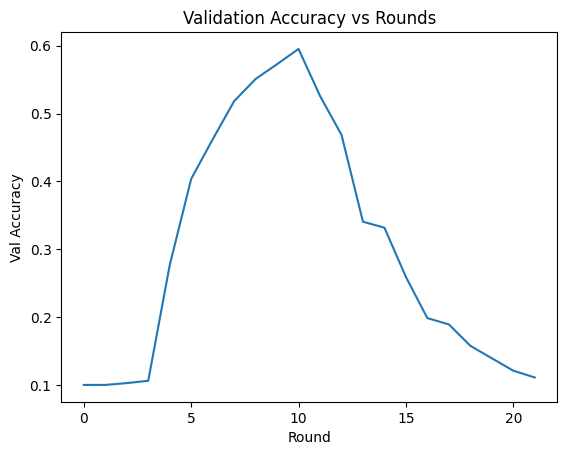

In [34]:
# plot the results
plt.plot(results)
plt.xlabel("Round")
plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy vs Rounds")
plt.savefig("val_accuracy.png")

results = []

In [37]:
import logging

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)
def multi_krum_aggregate(results: List[Tuple[NDArrays, int]], num_malicious: int, krum_k: int) -> NDArrays:
    n = len(results)
    if n <= num_malicious:
        raise ValueError("Number of clients must be greater than the number of malicious clients")

    # Extract weights
    weights = [res[0] for res in results]

    # Compute pairwise distances
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distances[i, j] = np.linalg.norm(np.concatenate([layer.flatten() for layer in weights[i]]) - 
                                             np.concatenate([layer.flatten() for layer in weights[j]]))
            distances[j, i] = distances[i, j]

    # Compute scores
    scores = np.zeros(n)
    for i in range(n):
        sorted_distances = np.sort(distances[i])
        scores[i] = np.sum(sorted_distances[:n - num_malicious - 2])

    # Select the top `krum_k` clients with the smallest scores
    krum_indices = np.argsort(scores)[:krum_k]
    selected_weights = [weights[i] for i in krum_indices]

    # Compute the average of the selected weights
    aggregated_weights = []
    for layer_index in range(len(selected_weights[0])):
        layer_weights = np.array([weights[layer_index] for weights in selected_weights])
        mean_layer_weights = np.mean(layer_weights, axis=0)
        aggregated_weights.append(mean_layer_weights)

    return aggregated_weights

class MultiKrumServer(FedAvg):
    def __init__(self, num_malicious: int, krum_k: int, **kwargs):
        super().__init__(**kwargs)
        self.num_malicious = num_malicious
        self.krum_k = krum_k

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}
        if not self.accept_failures and failures:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        aggregated_ndarrays = multi_krum_aggregate(weights_results, self.num_malicious, self.krum_k)

        parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:
            log.warning("No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated


In [38]:
strategy = MultiKrumServer(
    num_malicious=len(config["poison_clients"]),
    krum_k=config["num_clients"] - len(config["poison_clients"])-1,
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=config["num_clients"],
    min_evaluate_clients=config["num_clients"] // 2,
    min_available_clients=config["num_clients"],
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    evaluate_fn=evaluate,  # <-- pass the evaluation function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=config["num_clients"],
    config=fl.server.ServerConfig(num_rounds=config["epochs"],),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-05 09:02:03,363	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 14736659252.0, 'CPU': 4.0, 'GPU': 2.0, 'object_store_memory': 7368329625.0, 'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial globa

Server-side evaluation round 0
Test set performance:
	loss 0.018217530226707458
	accuracy 0.1
(ClientAppActor pid=2892) [Client 2, round 1] fit, server_round: 1, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 7, round 1] fit, server_round: 1, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 5, round 1] fit, server_round: 1, local_epochs: 1
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 0, round 1] fit, server_round: 1, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 1, round 1] fit, server_round: 1, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 8, round 1] fit, server_round: 1, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 1
Test set performance:
	loss 0.018116478562355043
	accuracy 0.1029


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.125}), (8, {'accuracy': 0.095}), (8, {'accuracy': 0.109}), (8, {'accuracy': 0.088}), (8, {'accuracy': 0.102})]
(ClientAppActor pid=2892) [Client 0, round 2] fit, server_round: 2, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 6, round 2] fit, server_round: 2, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training... [repeated 2x across cluster]
(ClientAppActor pid=2890) [Client 4, round 2] fit, server_round: 2, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 3, round 2] fit, server_round: 2, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 1, round 2] fit, server_round: 2, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 7, round 2] fit, server_round: 2, local_epochs: 1
(ClientAppActor pid=2892) Training.

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 2
Test set performance:
	loss 0.016836472940444946
	accuracy 0.2292


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.24}), (8, {'accuracy': 0.239}), (8, {'accuracy': 0.225}), (8, {'accuracy': 0.232}), (8, {'accuracy': 0.235})]
(ClientAppActor pid=2892) [Client 6, round 3] fit, server_round: 3, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 9, round 3] fit, server_round: 3, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2890) [Client 2, round 3] fit, server_round: 3, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training... [repeated 2x across cluster]
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 0, round 3] fit, server_round: 3, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 3, round 3] fit, server_round: 3, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 7, round 3] fit, server_roun

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 3
Test set performance:
	loss 0.01377783795595169
	accuracy 0.3593


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.357}), (8, {'accuracy': 0.414}), (8, {'accuracy': 0.377}), (8, {'accuracy': 0.354}), (8, {'accuracy': 0.375})]
(ClientAppActor pid=2892) [Client 6, round 4] fit, server_round: 4, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 5, round 4] fit, server_round: 4, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 0, round 4] fit, server_round: 4, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 4, round 4] fit, server_round: 4, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 2, round 4] fit, server_round: 4, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 8, round 4] fit, server_round: 4, local_epochs: 1
(ClientAppActor pid=2892) Training.

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=2892) updating......


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 4
Test set performance:
	loss 0.01200319412946701
	accuracy 0.4451


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.454}), (8, {'accuracy': 0.453}), (8, {'accuracy': 0.431}), (8, {'accuracy': 0.463}), (8, {'accuracy': 0.417})]
(ClientAppActor pid=2892) [Client 9, round 5] fit, server_round: 5, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 8, round 5] fit, server_round: 5, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 4, round 5] fit, server_round: 5, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 2, round 5] fit, server_round: 5, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 0, round 5] fit, server_round: 5, local_epochs: 3
(ClientAppActor pid=2890) [Client 1, round 5] fit, server_round: 5, local_epochs: 3
(ClientAppActor pid=2890) Training.

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 5
Test set performance:
	loss 0.011381466150283813
	accuracy 0.4726


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.434}), (8, {'accuracy': 0.446}), (8, {'accuracy': 0.458}), (8, {'accuracy': 0.472}), (8, {'accuracy': 0.457})]
(ClientAppActor pid=2892) [Client 1, round 6] fit, server_round: 6, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 3, round 6] fit, server_round: 6, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 2, round 6] fit, server_round: 6, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 8, round 6] fit, server_round: 6, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 5, round 6] fit, server_round: 6, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 6, round 6] fit, server_round: 6, l

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 6
Test set performance:
	loss 0.010520882999897002
	accuracy 0.5159


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.542}), (8, {'accuracy': 0.525}), (8, {'accuracy': 0.513}), (8, {'accuracy': 0.501}), (8, {'accuracy': 0.529})]
(ClientAppActor pid=2890) [Client 2, round 7] fit, server_round: 7, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 7, round 7] fit, server_round: 7, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 4, round 7] fit, server_round: 7, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 0, round 7] fit, server_round: 7, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 1, round 7] fit, server_round: 7, local_epochs: 3
(ClientAppActor pid=2890) [Client 3, round 7] fit, server_round: 7, local_epochs: 3
(ClientAppActor pid=2890) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 7
Test set performance:
	loss 0.009917903542518616
	accuracy 0.5503


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.551}), (8, {'accuracy': 0.562}), (8, {'accuracy': 0.576}), (8, {'accuracy': 0.548}), (8, {'accuracy': 0.553})]
(ClientAppActor pid=2892) [Client 7, round 8] fit, server_round: 8, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 8, round 8] fit, server_round: 8, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 9, round 8] fit, server_round: 8, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 2, round 8] fit, server_round: 8, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 1, round 8] fit, server_round: 8, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating.

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 8
Test set performance:
	loss 0.00948948154449463
	accuracy 0.5653


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.561}), (8, {'accuracy': 0.583}), (8, {'accuracy': 0.552}), (8, {'accuracy': 0.59}), (8, {'accuracy': 0.552})]
(ClientAppActor pid=2890) [Client 0, round 9] fit, server_round: 9, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 5, round 9] fit, server_round: 9, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 3, round 9] fit, server_round: 9, local_epochs: 3
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 4, round 9] fit, server_round: 9, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 7, round 9] fit, server_round: 9, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 1, round 9] fit, server_round: 9, local_epochs: 3
(ClientAppActor pid=2890) T

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 9
Test set performance:
	loss 0.008786539185047149
	accuracy 0.5949


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.617}), (8, {'accuracy': 0.586}), (8, {'accuracy': 0.612}), (8, {'accuracy': 0.582}), (8, {'accuracy': 0.586})]
(ClientAppActor pid=2892) [Client 2, round 10] fit, server_round: 10, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 3, round 10] fit, server_round: 10, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 7, round 10] fit, server_round: 10, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 9, round 10] fit, server_round: 10, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 0, round 10] fit, server_round: 10, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=28

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 10
Test set performance:
	loss 0.008420444369316101
	accuracy 0.614


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.606}), (8, {'accuracy': 0.609}), (8, {'accuracy': 0.63}), (8, {'accuracy': 0.6}), (8, {'accuracy': 0.609})]
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 6, round 11] fit, server_round: 11, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 2, round 11] fit, server_round: 11, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training... [repeated 2x across cluster]
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 0, round 11] fit, server_round: 11, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 3, round 11] fit, server_round: 11, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 8, round 11] fit, server_round: 11, local_epochs: 1 [repeated 2x across cluster]
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 1, round 11] fit, server_round: 11, local_epochs: 3
(ClientAppActor pid=2892) Training...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 11
Test set performance:
	loss 0.008744526094198226
	accuracy 0.6085


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.613}), (8, {'accuracy': 0.589}), (8, {'accuracy': 0.611}), (8, {'accuracy': 0.637}), (8, {'accuracy': 0.623})]
(ClientAppActor pid=2892) [Client 1, round 12] fit, server_round: 12, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 0, round 12] fit, server_round: 12, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 6, round 12] fit, server_round: 12, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 3, round 12] fit, server_round: 12, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 2, round 12] fit, server_round: 12, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updatin

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 12
Test set performance:
	loss 0.008247799640893937
	accuracy 0.627


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.623}), (8, {'accuracy': 0.64}), (8, {'accuracy': 0.645}), (8, {'accuracy': 0.654}), (8, {'accuracy': 0.623})]
(ClientAppActor pid=2892) [Client 8, round 13] fit, server_round: 13, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 9, round 13] fit, server_round: 13, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 4, round 13] fit, server_round: 13, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 5, round 13] fit, server_round: 13, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 2, round 13] fit, server_round: 13, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 1, round 13] fit, server_round: 13, local_epochs: 3
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 6, round 13] 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 13
Test set performance:
	loss 0.008366482937335967
	accuracy 0.6302


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.647}), (8, {'accuracy': 0.618}), (8, {'accuracy': 0.632}), (8, {'accuracy': 0.622}), (8, {'accuracy': 0.634})]
(ClientAppActor pid=2892) [Client 3, round 14] fit, server_round: 14, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 2, round 14] fit, server_round: 14, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 7, round 14] fit, server_round: 14, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 0, round 14] fit, server_round: 14, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 1, round 14] fit, server_round: 14, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 5, round 14] fit, server_

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 14
Test set performance:
	loss 0.008114066445827484
	accuracy 0.6418


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.657}), (8, {'accuracy': 0.648}), (8, {'accuracy': 0.668}), (8, {'accuracy': 0.645}), (8, {'accuracy': 0.647})]
(ClientAppActor pid=2892) [Client 4, round 15] fit, server_round: 15, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 7, round 15] fit, server_round: 15, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training... [repeated 2x across cluster]
(ClientAppActor pid=2890) [Client 2, round 15] fit, server_round: 15, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 0, round 15] fit, server_round: 15, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 6, round 15] fit, server_round: 15, local_epochs: 1
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 15
Test set performance:
	loss 0.008435171502828598
	accuracy 0.6326


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.647}), (8, {'accuracy': 0.655}), (8, {'accuracy': 0.65}), (8, {'accuracy': 0.664}), (8, {'accuracy': 0.647})]
(ClientAppActor pid=2890) [Client 5, round 16] fit, server_round: 16, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 2, round 16] fit, server_round: 16, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 3, round 16] fit, server_round: 16, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 6, round 16] fit, server_round: 16, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 1, round 16] fit, server_round: 16, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 16
Test set performance:
	loss 0.00856349042057991
	accuracy 0.6399


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.639}), (8, {'accuracy': 0.667}), (8, {'accuracy': 0.637}), (8, {'accuracy': 0.662}), (8, {'accuracy': 0.662})]
(ClientAppActor pid=2892) [Client 5, round 17] fit, server_round: 17, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 4, round 17] fit, server_round: 17, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) [Client 3, round 17] fit, server_round: 17, local_epochs: 3
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 9, round 17] fit, server_round: 17, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) [Client 6, round 17] fit, server_round: 17, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 7, round 17] fit, server_round: 17, local_epochs: 1
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=2892) updating......


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 17
Test set performance:
	loss 0.009635869407653808
	accuracy 0.6169


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.636}), (8, {'accuracy': 0.633}), (8, {'accuracy': 0.633}), (8, {'accuracy': 0.636}), (8, {'accuracy': 0.635})]
(ClientAppActor pid=2890) [Client 1, round 18] fit, server_round: 18, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 5, round 18] fit, server_round: 18, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 9, round 18] fit, server_round: 18, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 0, round 18] fit, server_round: 18, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 8, round 18] fit, server_round: 18, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 3, round 18] fit, server_round: 18, local_epochs: 3
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 18
Test set performance:
	loss 0.008909406453371047
	accuracy 0.6474


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.651}), (8, {'accuracy': 0.671}), (8, {'accuracy': 0.642}), (8, {'accuracy': 0.658}), (8, {'accuracy': 0.663})]
(ClientAppActor pid=2890) [Client 0, round 19] fit, server_round: 19, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2892) [Client 1, round 19] fit, server_round: 19, local_epochs: 3
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) [Client 6, round 19] fit, server_round: 19, local_epochs: 1
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 3, round 19] fit, server_round: 19, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2892) [Client 8, round 19] fit, server_round: 19, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pi

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 19
Test set performance:
	loss 0.008660110354423522
	accuracy 0.6597


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


[(8, {'accuracy': 0.69}), (8, {'accuracy': 0.683}), (8, {'accuracy': 0.679}), (8, {'accuracy': 0.664}), (8, {'accuracy': 0.67})]
(ClientAppActor pid=2892) [Client 6, round 20] fit, server_round: 20, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2892) Training... [repeated 2x across cluster]
(ClientAppActor pid=2892) [Client 1, round 20] fit, server_round: 20, local_epochs: 3 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2892) updating......
(ClientAppActor pid=2890) [Client 0, round 20] fit, server_round: 20, local_epochs: 3
(ClientAppActor pid=2890) Training...
(ClientAppActor pid=2892) [Client 9, round 20] fit, server_round: 20, local_epochs: 1
(ClientAppActor pid=2892) Training...
(ClientAppActor pid=2890) updating......
(ClientAppActor pid=2890) [Client 7, round 20] fit, server_round: 20, local_epochs: 1 [repeated 2x across cluster]
(ClientAppActor pid=2890) Training... [repeated 2x ac

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Server-side evaluation round 20
Test set performance:
	loss 0.010137220132350922
	accuracy 0.6319


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 rounds in 1526.17s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.018435634994506837\n'
INFO :      	 '\tround 2: 0.016968896865844723\n'
INFO :      	 '\tround 3: 0.01365246889591217\n'
INFO :      	 '\tround 4: 0.012004596495628357\n'
INFO :      	 '\tround 5: 0.011764718508720398\n'
INFO :      	 '\tround 6: 0.010617996644973754\n'
INFO :      	 '\tround 7: 0.009798711609840393\n'
INFO :      	 '\tround 8: 0.009528928899765015\n'
INFO :      	 '\tround 9: 0.008820329320430757\n'
INFO :      	 '\tround 10: 0.008435192799568175\n'
INFO :      	 '\tround 11: 0.00868752989768982\n'
INFO :      	 '\tround 12: 0.008206202423572541\n'
INFO :      	 '\tround 13: 0.008363035321235657\n'
INFO :      	 '\tround 14: 0.007883490180969238\n'
INFO :      	 '\tround 15: 0.008117261624336241\n'
INFO :      	 '\tround 16: 0.008323222064971924\n'
INFO :

[(8, {'accuracy': 0.646}), (8, {'accuracy': 0.651}), (8, {'accuracy': 0.631}), (8, {'accuracy': 0.635}), (8, {'accuracy': 0.638})]


History (loss, distributed):
('\tround 1: 0.018435634994506837\n'
 '\tround 2: 0.016968896865844723\n'
 '\tround 3: 0.01365246889591217\n'
 '\tround 4: 0.012004596495628357\n'
 '\tround 5: 0.011764718508720398\n'
 '\tround 6: 0.010617996644973754\n'
 '\tround 7: 0.009798711609840393\n'
 '\tround 8: 0.009528928899765015\n'
 '\tround 9: 0.008820329320430757\n'
 '\tround 10: 0.008435192799568175\n'
 '\tround 11: 0.00868752989768982\n'
 '\tround 12: 0.008206202423572541\n'
 '\tround 13: 0.008363035321235657\n'
 '\tround 14: 0.007883490180969238\n'
 '\tround 15: 0.008117261624336241\n'
 '\tround 16: 0.008323222064971924\n'
 '\tround 17: 0.009197559142112732\n'
 '\tround 18: 0.008606334733963012\n'
 '\tround 19: 0.008163364994525909\n'
 '\tround 20: 0.009867533123493194\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.1038),
              (2, 0.23419999999999996),
              (3, 0.37539999999999996),
              (4, 0.4436),
              (5, 0.45339999999999997),
      

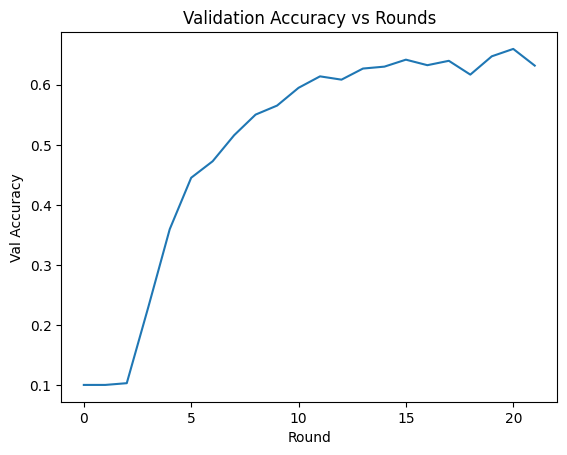

In [39]:
# plot the results
plt.plot(results)
plt.xlabel("Round")
plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy vs Rounds")
plt.savefig("val_accuracy.png")

results = []